In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train = pd.read_csv('Data/capstone_train.csv')
test = pd.read_csv('Data/capstone_test.csv')
combined_data = pd.concat((train,test))
combined_data

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1.0
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3.0
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3.0
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3.0
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109536,10273846,"15,000",9 years,Mortgage,120000.0,VERIFIED - income,other,8.15,2,32.0,13,57,Male,NaN
109537,10273847,"9,600",10+ years,Mortgage,125000.0,not verified,credit_card,9.08,1,17.0,9,34,Male,NaN
109538,10273848,"2,000",5 years,Rent,37850.0,not verified,credit_card,11.60,0,NaN,10,11,Male,NaN
109539,10273849,"2,125",6 years,Rent,30000.0,not verified,other,24.88,0,NaN,5,6,Male,NaN


In [3]:
def lar(x):
    return int(x.replace(',',''))
combined_data['Loan_Amount_Requested'] = combined_data['Loan_Amount_Requested'].apply(lar)

In [4]:
combined_data.drop('Loan_ID',axis = 1,inplace = True)

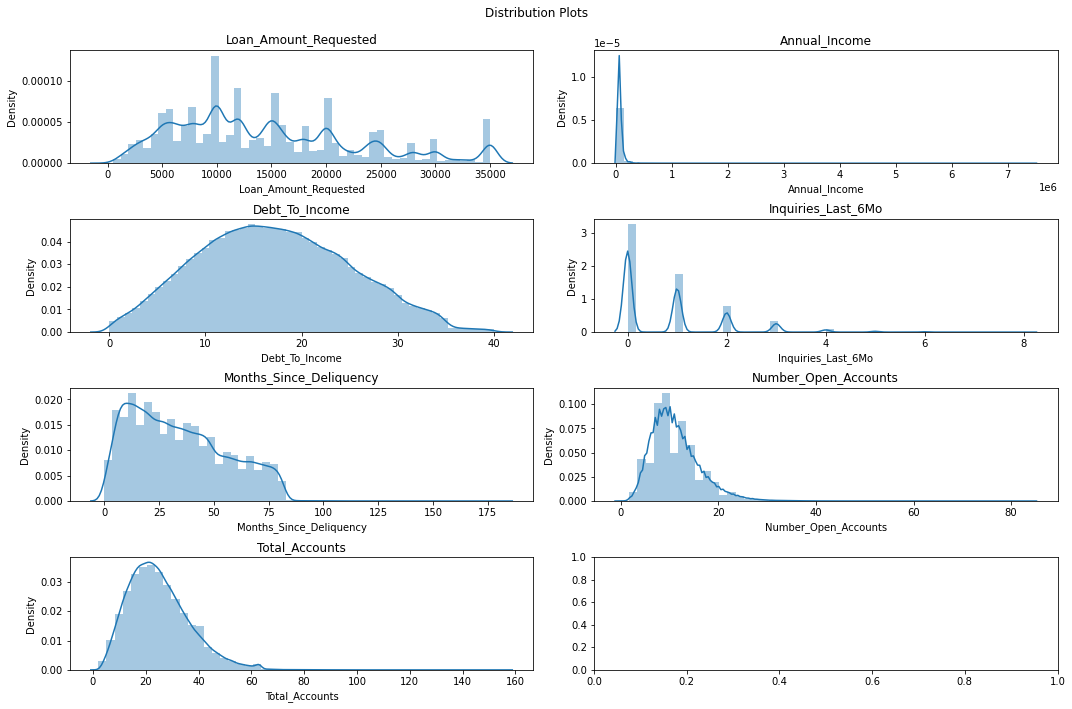

In [5]:
train = combined_data.copy()
dist_data = train.select_dtypes(np.number).drop('Interest_Rate',axis = 1)
fig,ax = plt.subplots(4,2,figsize = (15,10))
for variables,plotsubs in zip(dist_data.columns,ax.flatten()):
    plotsubs.set_title(variables)
    sns.distplot(dist_data[variables],ax = plotsubs)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.92)
fig.suptitle('Distribution Plots')
plt.show()

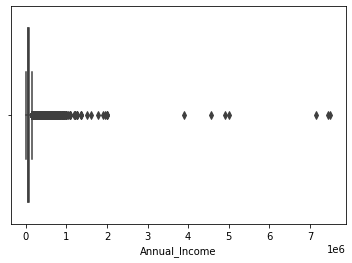

In [6]:
sns.boxplot(combined_data['Annual_Income'])
plt.show()
#Let us apply some capping

###### Removing Outliers

In [7]:
upper_limit = combined_data.quantile(0.99)
rdata1 = combined_data[~((combined_data>upper_limit).any(axis = 1))]
rdata1.shape

(261889, 13)

In [8]:
# def capping(train,col_name):
#     Q1 = train[col_name].quantile(0.25)
#     Q3 = train[col_name].quantile(0.75)
#     IQR = Q3-Q1
#     upper = Q3+1.5*IQR
#     lower = Q1-1.5*IQR
#     train[col_name][train[col_name]>upper]=train[col_name].quantile(0.99)

In [9]:
# for i in rdata1.select_dtypes(np.number).drop('Interest_Rate',axis = 1):
#     capping(rdata1,i)

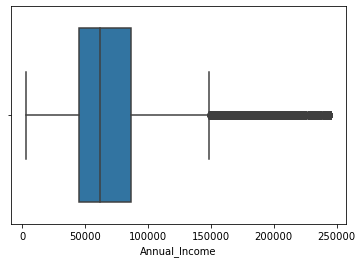

In [10]:
sns.boxplot(rdata1['Annual_Income'])
plt.show()

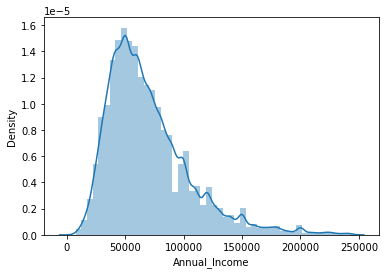

In [11]:
sns.distplot(rdata1['Annual_Income'])

In [12]:
rdata = rdata1.copy()

In [13]:
#Imputing the missing values.
rdata.isna().sum()[rdata.isna().sum()>0]/len(rdata) #We will not consider the interest rate for missing values for now.

Length_Employed            0.044943
Home_Owner                 0.153611
Annual_Income              0.154390
Months_Since_Deliquency    0.542547
Interest_Rate              0.399688
dtype: float64

In [14]:
rdata2 = rdata.drop('Months_Since_Deliquency',axis = 1) #Maybe can impute as -99 but since it has many miss values so dont know

In [15]:
rdata2.isna().sum()[rdata2.isna().sum()>0]/len(rdata2)

Length_Employed    0.044943
Home_Owner         0.153611
Annual_Income      0.154390
Interest_Rate      0.399688
dtype: float64

In [16]:
knn_data = rdata.select_dtypes(np.number).iloc[:,:-1]
cat_data = rdata.select_dtypes('object')

In [17]:
knn_data['Months_Since_Deliquency'] = knn_data['Months_Since_Deliquency'].fillna(-99)

In [18]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_scaled = pd.DataFrame(ss.fit_transform(knn_data),columns = knn_data.columns)



#Using KNNImputer to fill Annual_Income
import time
start = time.time()
from sklearn.impute import KNNImputer
knn_impute = KNNImputer(n_neighbors = 5)
num_data = knn_impute.fit_transform(data_scaled)
num_data = pd.DataFrame(num_data,columns = knn_data.columns)
end = time.time()
print('Execution Time:',(end-start)/60)


num_data = pd.DataFrame(ss.inverse_transform(num_data),columns = knn_data.columns).apply(round)
num_data = num_data.replace(-0,0)

Execution Time: 14.182730015118917


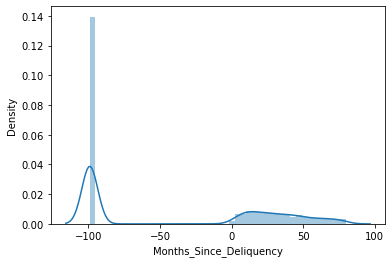

In [19]:
#Months_Since_Deliquency filled with KNNImputer
sns.distplot(num_data['Months_Since_Deliquency'])
plt.show()

In [20]:
num_data.head()

,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts
0,7000.0,68000.0,18.0,0.0,-99.0,9.0,14.0
1,30000.0,102880.0,15.0,0.0,17.0,12.0,24.0
2,24725.0,75566.0,16.0,0.0,-99.0,12.0,16.0
3,16000.0,56160.0,14.0,3.0,-99.0,16.0,22.0
4,17000.0,96000.0,22.0,1.0,-99.0,19.0,30.0


In [21]:
#Fill categorical columns with mode
cat_data.isna().sum()[cat_data.isna().sum()!=0]/len(cat_data)

Length_Employed    0.044943
Home_Owner         0.153611
dtype: float64

In [38]:
#Combine categorical and numberical columns
combined_data = pd.concat((num_data.reset_index(drop = True),cat_data.reset_index(drop = True),rdata2['Interest_Rate'].reset_index(drop = True)),axis = 1)
combined_data.to_csv('Data/25-03_Imputed_Data.csv',index = False)

# Run from here

In [100]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [101]:
combined_data = pd.read_csv('Data/25-03_Imputed_Data.csv')

In [102]:
#Treating the categorical column
combined_data.isna().sum()[combined_data.isna().sum()!=0]/len(combined_data)

Length_Employed    0.044943
Home_Owner         0.153611
Interest_Rate      0.399688
dtype: float64

In [103]:
#For length employed, use the annual income medians and use this to fill the length_employed

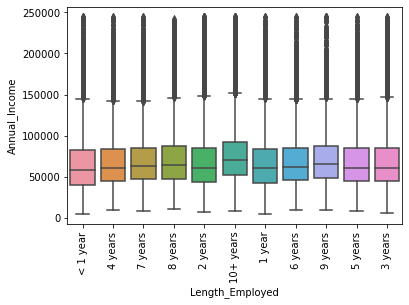

In [104]:
sns.boxplot(combined_data['Length_Employed'],combined_data['Annual_Income'])
plt.xticks(rotation = 90)
plt.show()

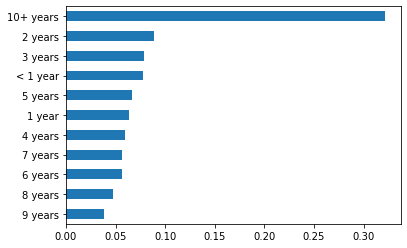

In [105]:
(combined_data['Length_Employed'].value_counts()/len(combined_data['Length_Employed'])).sort_values(ascending = True).plot(kind = 'barh')
plt.show()

In [106]:
combined_data['Length_Employed'] = combined_data['Length_Employed'].fillna(combined_data['Length_Employed'].mode().values[0])

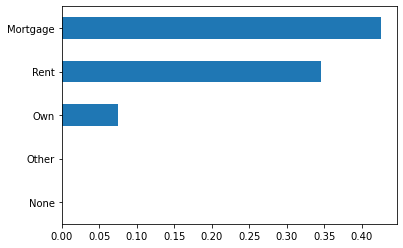

In [107]:
(combined_data['Home_Owner'].value_counts()/len(combined_data)).sort_values(ascending = True).plot(kind = 'barh')

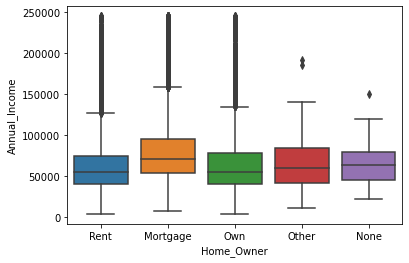

In [108]:
sns.boxplot(combined_data['Home_Owner'],combined_data['Annual_Income'])

In [109]:
combined_data.groupby('Home_Owner')['Annual_Income'].median()

Home_Owner
Mortgage    71600.0
None        64000.0
Other       60000.0
Own         55000.0
Rent        55000.0
Name: Annual_Income, dtype: float64

In [110]:
combined_data.groupby(['Length_Employed'])['Home_Owner'].count()

Length_Employed
1 year       14135
10+ years    81122
2 years      19808
3 years      17417
4 years      13317
5 years      14683
6 years      12496
7 years      12470
8 years      10608
9 years       8502
< 1 year     17102
Name: Home_Owner, dtype: int64

In [111]:
combined_data.groupby(['Length_Employed'])['Home_Owner'].agg(lambda x:x.value_counts().index[0])

Length_Employed
1 year           Rent
10+ years    Mortgage
2 years          Rent
3 years          Rent
4 years          Rent
5 years      Mortgage
6 years      Mortgage
7 years      Mortgage
8 years      Mortgage
9 years      Mortgage
< 1 year         Rent
Name: Home_Owner, dtype: object

In [112]:
combined_data['Home_Owner'] = combined_data['Home_Owner'].fillna(combined_data.groupby(['Length_Employed'])['Home_Owner'].transform(lambda x:x.value_counts().index[0]))

In [114]:
combined_data.shape #All null values filled
combined_data.to_csv('Data/25-03_Imputed_Data.csv',index=False)

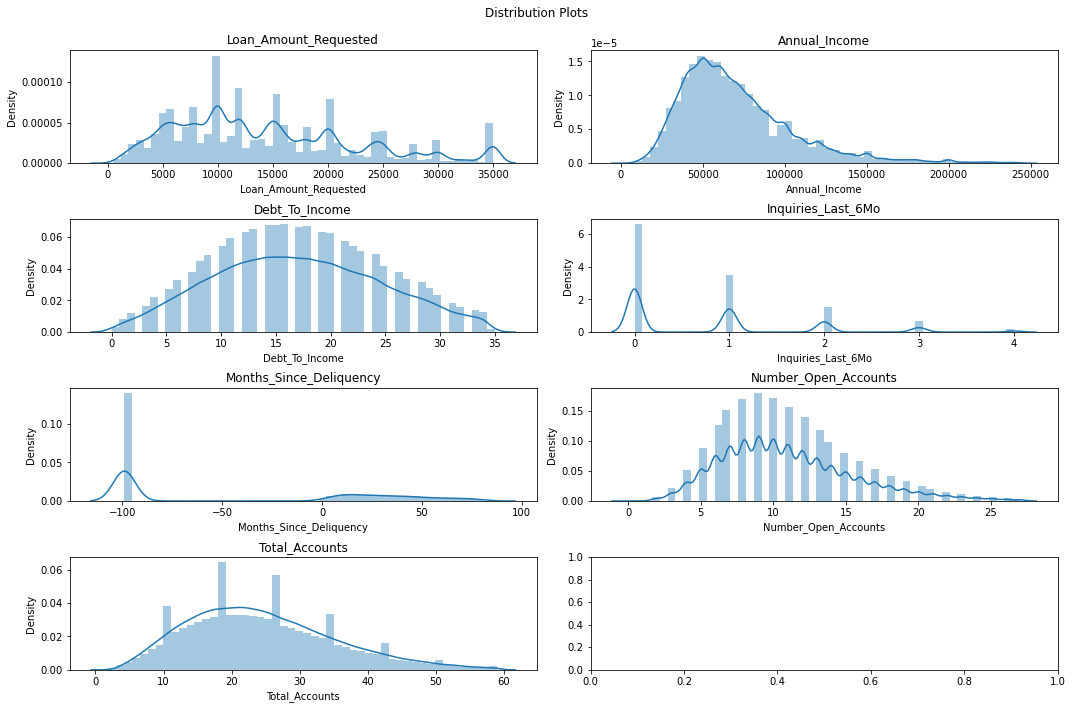

In [54]:
train = combined_data.copy()
dist_data = train.select_dtypes(np.number).drop('Interest_Rate',axis = 1)
fig,ax = plt.subplots(4,2,figsize = (15,10))
for variables,plotsubs in zip(dist_data.columns,ax.flatten()):
    plotsubs.set_title(variables)
    sns.distplot(dist_data[variables],ax = plotsubs)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.92)
fig.suptitle('Distribution Plots')
plt.show()

In [55]:
combined_data['Income_Verified'] = combined_data['Income_Verified'].map({'VERIFIED - income source':'VERIFIED - income',
                                     'VERIFIED - income':'VERIFIED - income',
                                     'not verified':'not verified'})

#### For testing

In [56]:
data = combined_data.dropna().copy()

###### Imputations

In [57]:
def len_emp(x):
    return int(x.strip().strip('<').strip('year').strip('years').strip().strip('+'))
data['Length_Employed'] = data['Length_Employed'].apply(len_emp)

In [58]:
#Using One Hot encoding for rest of the columns
model_data = pd.get_dummies(data)
model_data.head(2)

,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Length_Employed,Interest_Rate,Home_Owner_Mortgage,...,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding,Gender_Female,Gender_Male
0,7000.0,68000.0,18.0,0.0,-99.0,9.0,14.0,1,1.0,0,...,0,0,0,0,0,0,0,0,1,0
1,30000.0,102880.0,15.0,0.0,17.0,12.0,24.0,4,3.0,1,...,0,0,0,0,0,0,0,0,1,0


###### Modelling

In [59]:
#Preparing the dataset
X = model_data.drop(['Interest_Rate'],axis = 1)
y = model_data['Interest_Rate']

#Train Test Split
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.3,random_state = 12)

In [60]:
#Importing all model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

In [61]:
#Initialize all models
clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()
clf3 = RandomForestClassifier()
clf4 = AdaBoostClassifier()
clf5 = GradientBoostingClassifier()
clf6 = XGBClassifier()
clf7 = CatBoostClassifier()

In [62]:
mod = [clf1,clf2,clf3,clf4,clf5,clf6,clf7]
mod_name = ['LR','DTC','RF','AdaBst','GBC','XGB','CAT']
for i,j in zip(mod,mod_name):
    scores = cross_val_score(i,X,y,scoring = 'f1_weighted',cv = 5,n_jobs = -1)
    avg_score = round(np.mean(scores),4)
    var_score = round(np.std(scores)/avg_score,4)
    print(j,'Average Score (f1): ',avg_score,'Variance Error: ',var_score)

LR Average Score (f1):  0.4214 Variance Error:  0.0178
DTC Average Score (f1):  0.4268 Variance Error:  0.0073
RF Average Score (f1):  0.5011 Variance Error:  0.0056
AdaBst Average Score (f1):  0.5132 Variance Error:  0.0007
GBC Average Score (f1):  0.5147 Variance Error:  0.0049
XGB Average Score (f1):  0.5276 Variance Error:  0.0034
CAT Average Score (f1):  0.5288 Variance Error:  0.0031


In [63]:
#RandomForest,AdaBoost,GradientBoosting and XGB Algorithms will be used from here on.

In [64]:
#Trying to improve above model
#Checking for multicollinearity in numerical columns
e = data.drop(['Interest_Rate','Total_Accounts'],axis = 1).select_dtypes(np.number)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
scores = []
for i in range(len(e.columns)):
    scores.append(vif(e.values,i))
pd.DataFrame({'Features':e.columns,'VIF':scores})

,Features,VIF
0,Loan_Amount_Requested,5.619192
1,Annual_Income,6.659001
2,Debt_To_Income,5.818593
3,Inquiries_Last_6Mo,1.592630
4,Months_Since_Deliquency,1.284333
5,Number_Open_Accounts,7.715000
6,Length_Employed,3.657437


In [65]:
#Preparing the dataset
X1 = model_data.drop(['Interest_Rate','Total_Accounts'],axis = 1)
y1 = model_data['Interest_Rate']

#Train Test Split
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X1,y1,test_size = 0.3,random_state = 12)

In [66]:
mod = [clf1,clf2,clf3,clf4,clf5,clf6,clf7]
mod_name = ['LR','DTC','RF','AdaBst','GBC','XGB','CAT']
for i,j in zip(mod,mod_name):
    scores = cross_val_score(i,X1,y1,scoring = 'f1_weighted',cv = 5,n_jobs = -1)
    avg_score = round(np.mean(scores),4)
    var_score = round(np.std(scores)/avg_score,4)
    print(j,'Average Score (f1): ',avg_score,'Variance Error: ',var_score)

LR Average Score (f1):  0.4328 Variance Error:  0.0022
DTC Average Score (f1):  0.4232 Variance Error:  0.0027
RF Average Score (f1):  0.4918 Variance Error:  0.0024
AdaBst Average Score (f1):  0.5056 Variance Error:  0.0019
GBC Average Score (f1):  0.5079 Variance Error:  0.0044
XGB Average Score (f1):  0.52 Variance Error:  0.0036
CAT Average Score (f1):  0.5202 Variance Error:  0.0041


In [67]:
#Performing ANOVA test to check which numerical columns have most impact on target
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('Interest_Rate~Loan_Amount_Requested+Annual_Income+Debt_To_Income+Inquiries_Last_6Mo+Months_Since_Deliquency+Number_Open_Accounts+Total_Accounts',model_data).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Loan_Amount_Requested,1.0,1525.082597,1525.082597,3187.527183,0.000000e+00
Annual_Income,1.0,2112.089296,2112.089296,4414.411426,0.000000e+00
Debt_To_Income,1.0,799.045346,799.045346,1670.059553,0.000000e+00
Inquiries_Last_6Mo,1.0,3597.628650,3597.628650,7519.290519,0.000000e+00
Months_Since_Deliquency,1.0,1146.605474,1146.605474,2396.484047,0.000000e+00
Number_Open_Accounts,1.0,403.193010,403.193010,842.701033,8.674711e-185
Total_Accounts,1.0,989.341902,989.341902,2067.792401,0.000000e+00
Residual,157207.0,75216.193039,0.478453,NaN,NaN


In [68]:
sm.stats.anova_lm(model).loc[:,'PR(>F)']>0.05

Loan_Amount_Requested      False
Annual_Income              False
Debt_To_Income             False
Inquiries_Last_6Mo         False
Months_Since_Deliquency    False
Number_Open_Accounts       False
Total_Accounts             False
Residual                   False
Name: PR(>F), dtype: bool

In [69]:
#Having more open accounts should mean that customers should get a higher interest rate
data.groupby('Interest_Rate')['Number_Open_Accounts'].mean()
#We can see that Number_Open_Accounts is similar for all 3 categories for interest rate

Interest_Rate
1.0    11.061611
2.0    10.824905
3.0    10.988468
Name: Number_Open_Accounts, dtype: float64

In [70]:
#Checking Number closed accounts
data['Number_Closed_Accounts'] = data['Total_Accounts']-data['Number_Open_Accounts']

count    157215.000000
mean         13.505098
std           8.492973
min           0.000000
25%           7.000000
50%          12.000000
75%          19.000000
max          54.000000
Name: Number_Closed_Accounts, dtype: float64

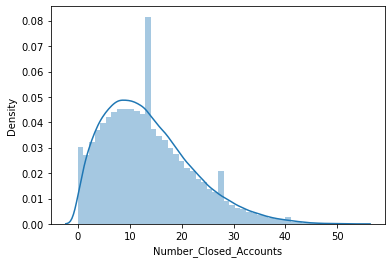

In [71]:
sns.distplot(data['Number_Closed_Accounts'])
data['Number_Closed_Accounts'].describe()

In [72]:
data.groupby('Interest_Rate')['Number_Closed_Accounts'].mean()
#We can see that there is some difference in the mean of closed accounts for each interest rate

Interest_Rate
1.0    14.601334
2.0    13.340740
3.0    13.070162
Name: Number_Closed_Accounts, dtype: float64

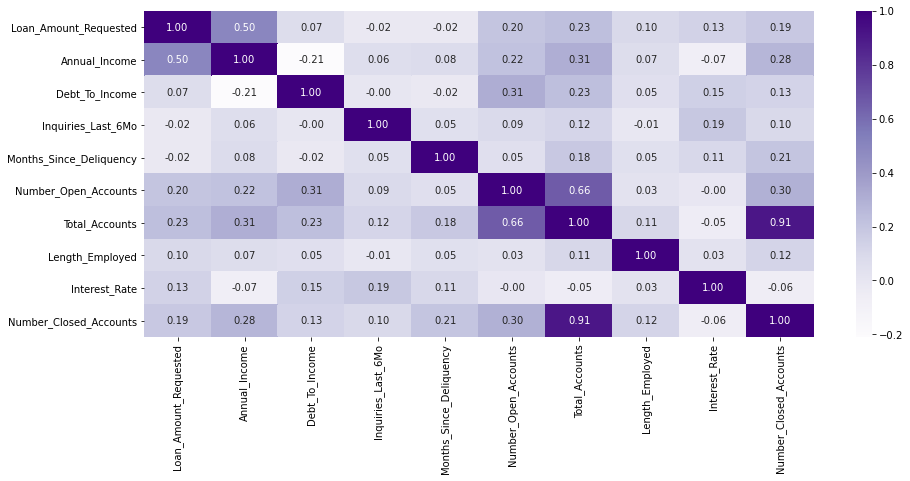

In [73]:
plt.figure(figsize = (15,6))
sns.heatmap(data.corr(),annot = True,fmt = '.2f',cmap = 'Purples')
plt.show()

In [74]:
data = data.drop('Total_Accounts',axis = 1)

In [75]:
data.groupby('Interest_Rate')['Annual_Income'].mean()
#There is a difference in mean between Annual Income for interest rate 1 and the other 2 categories.

Interest_Rate
1.0    76508.221053
2.0    68424.786945
3.0    68928.038294
Name: Annual_Income, dtype: float64

In [76]:
#Maybe the debt_to_income ratio is in percentage
data['Monthly_Income'] = round(data['Annual_Income']/12)

In [77]:
#Calculating the monthly debt
data['Monthly_Debt'] = round(data['Monthly_Income'] * data['Debt_To_Income']/100)

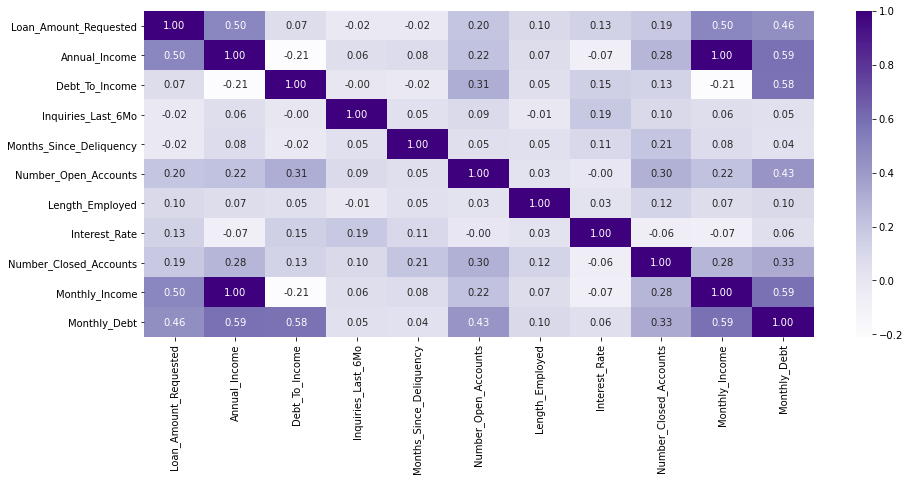

In [78]:
plt.figure(figsize = (15,6))
sns.heatmap(data.corr(),annot = True,fmt = '.2f',cmap = 'Purples')
plt.show()

In [79]:
#Trying to improve above model
#Checking for multicollinearity in numerical columns
e = data.drop(['Interest_Rate','Annual_Income','Debt_To_Income'],axis = 1).select_dtypes(np.number)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
scores = []
for i in range(len(e.columns)):
    scores.append(vif(e.values,i))
pd.DataFrame({'Features':e.columns,'VIF':scores})

,Features,VIF
0,Loan_Amount_Requested,5.586696
1,Inquiries_Last_6Mo,1.599374
2,Months_Since_Deliquency,1.296296
3,Number_Open_Accounts,6.596498
4,Length_Employed,3.473430
5,Number_Closed_Accounts,4.268766
6,Monthly_Income,8.173938
7,Monthly_Debt,7.096945


In [80]:
data3 = data.drop(['Annual_Income','Debt_To_Income'],axis = 1)
data3.head()

,Loan_Amount_Requested,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Length_Employed,Home_Owner,Income_Verified,Purpose_Of_Loan,Gender,Interest_Rate,Number_Closed_Accounts,Monthly_Income,Monthly_Debt
0,7000.0,0.0,-99.0,9.0,1,Rent,not verified,car,Female,1.0,5.0,5667.0,1020.0
1,30000.0,0.0,17.0,12.0,4,Mortgage,VERIFIED - income,debt_consolidation,Female,3.0,12.0,8573.0,1286.0
2,24725.0,0.0,-99.0,12.0,7,Mortgage,VERIFIED - income,debt_consolidation,Male,3.0,4.0,6297.0,1008.0
3,16000.0,3.0,-99.0,16.0,1,Rent,VERIFIED - income,debt_consolidation,Male,3.0,6.0,4680.0,655.0
4,17000.0,1.0,-99.0,19.0,8,Own,VERIFIED - income,debt_consolidation,Female,1.0,11.0,8000.0,1760.0


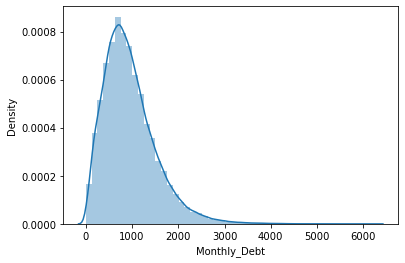

In [81]:
sns.distplot(data3['Monthly_Debt'])

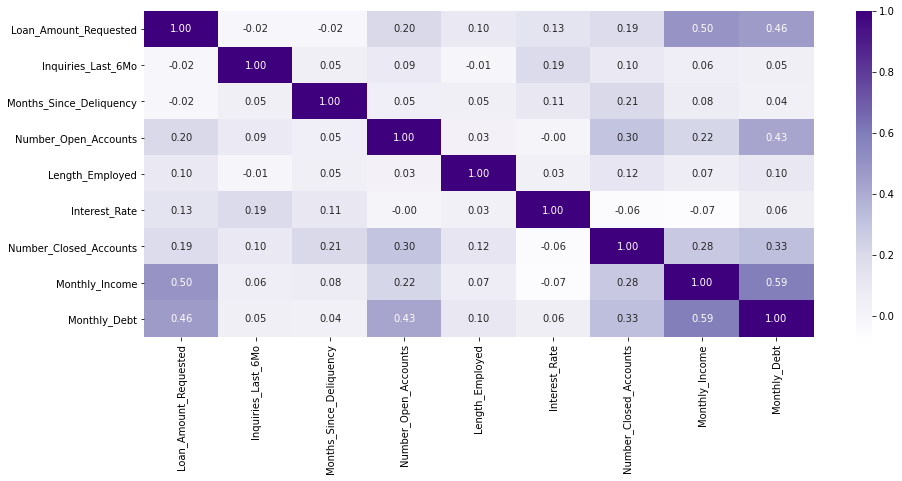

In [82]:
plt.figure(figsize = (15,6))
sns.heatmap(data3.corr(),annot = True,fmt = '.2f',cmap = 'Purples')
plt.show()

In [83]:
model_data = pd.get_dummies(data3)
model_data.head()

,Loan_Amount_Requested,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Length_Employed,Interest_Rate,Number_Closed_Accounts,Monthly_Income,Monthly_Debt,Home_Owner_Mortgage,...,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding,Gender_Female,Gender_Male
0,7000.0,0.0,-99.0,9.0,1,1.0,5.0,5667.0,1020.0,0,...,0,0,0,0,0,0,0,0,1,0
1,30000.0,0.0,17.0,12.0,4,3.0,12.0,8573.0,1286.0,1,...,0,0,0,0,0,0,0,0,1,0
2,24725.0,0.0,-99.0,12.0,7,3.0,4.0,6297.0,1008.0,1,...,0,0,0,0,0,0,0,0,0,1
3,16000.0,3.0,-99.0,16.0,1,3.0,6.0,4680.0,655.0,0,...,0,0,0,0,0,0,0,0,0,1
4,17000.0,1.0,-99.0,19.0,8,1.0,11.0,8000.0,1760.0,0,...,0,0,0,0,0,0,0,0,1,0


In [84]:
#Preparing the dataset
X1 = model_data.drop(['Interest_Rate'],axis = 1)
y1 = model_data['Interest_Rate']

#Train Test Split
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X1,y1,test_size = 0.3,random_state = 12)

In [85]:
mod = [clf1,clf2,clf3,clf4,clf5,clf6,clf7]
mod_name = ['LR','DTC','RF','AdaBst','GBC','XGB','CAT']
for i,j in zip(mod,mod_name):
    scores = cross_val_score(i,X1,y1,scoring = 'f1_weighted',cv = 5,n_jobs = -1)
    avg_score = round(np.mean(scores),4)
    var_score = round(np.std(scores)/avg_score,4)
    print(j,'Average Score (f1): ',avg_score,'Variance Error: ',var_score)


LR Average Score (f1):  0.4291 Variance Error:  0.0046
DTC Average Score (f1):  0.4263 Variance Error:  0.0084
RF Average Score (f1):  0.5002 Variance Error:  0.0034
AdaBst Average Score (f1):  0.5123 Variance Error:  0.0026
GBC Average Score (f1):  0.5142 Variance Error:  0.0027
XGB Average Score (f1):  0.528 Variance Error:  0.0012
CAT Average Score (f1):  0.53 Variance Error:  0.0029


In [86]:
#Create a new feature called Assets,Liability,Other from Purpose_Of_Loan
def purp_bin(x):
    assets = [ 'home_improvement','renewable_energy','house','educational','small_business']
    liabilities = ['car','debt_consolidation','credit_card']
    other = ['major_purchase', 'other', 'medical', 'moving','wedding','vacation']
    if x in assets:
        return 'asset'
    elif x in liabilities:
        return 'liability'
    elif x in other:
        return 'misc.'
data3['Loan for Assets/Liabilities'] = data3['Purpose_Of_Loan'].apply(purp_bin)

In [87]:
model_data = pd.get_dummies(data3)
#Preparing the dataset
X1 = model_data.drop(['Interest_Rate'],axis = 1)
y1 = model_data['Interest_Rate']

#Train Test Split
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X1,y1,test_size = 0.3,random_state = 12)

In [88]:
mod = [clf1,clf2,clf3,clf4,clf5,clf6,clf7]
mod_name = ['LR','DTC','RF','AdaBst','GBC','XGB','CAT']
for i,j in zip(mod,mod_name):
    scores = cross_val_score(i,X1,y1,scoring = 'f1_weighted',cv = 5,n_jobs = -1)
    avg_score = np.mean(scores)
    var_score = np.std(scores)/avg_score
    print(j,'Average Score (f1): ',avg_score,'Variance Error: ',var_score)

LR Average Score (f1):  0.42919911314185627 Variance Error:  0.005406661544773744
DTC Average Score (f1):  0.426354235439484 Variance Error:  0.007857537804985501
RF Average Score (f1):  0.49997936489007067 Variance Error:  0.006399880224073207
AdaBst Average Score (f1):  0.5123048714377619 Variance Error:  0.0025646377281238883
GBC Average Score (f1):  0.5150076937294596 Variance Error:  0.003613864846098317
XGB Average Score (f1):  0.5272734473155237 Variance Error:  0.002899738634926163
CAT Average Score (f1):  0.529069373005309 Variance Error:  0.0028770072293417756


In [89]:
#Loan EMI on monthly basis should not exceed 45% So using this fact we will calculate monthly EMI for the requested amount
data3['Expected_EMI'] = 0.40*(data3['Monthly_Income']-data3['Monthly_Debt'])

In [90]:
#Now we can also calculate that for how many months will a person have to pay to cover his loan amount
import math
data3['Loan_Amt_Recovery_Months'] = (data3['Loan_Amount_Requested']/data3['Expected_EMI']).apply(np.ceil)

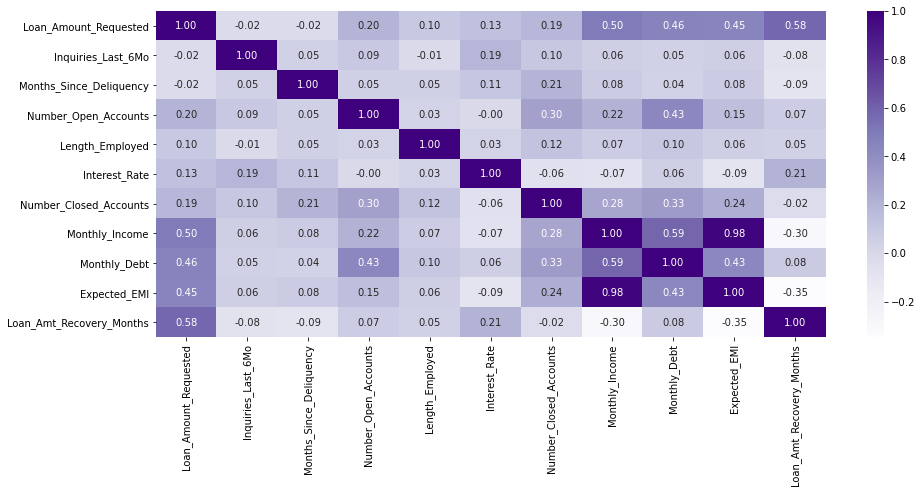

In [91]:
plt.figure(figsize = (15,6))
sns.heatmap(data3.corr(),annot = True,fmt = '.2f',cmap = 'Purples')
plt.show()

In [92]:
model_data = pd.get_dummies(data3)
#Preparing the dataset
X1 = model_data.drop(['Interest_Rate'],axis = 1)
y1 = model_data['Interest_Rate']

#Train Test Split
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X1,y1,test_size = 0.3,random_state = 12)

In [93]:
mod = [clf1,clf2,clf3,clf4,clf5,clf6,clf7]
mod_name = ['LR','DTC','RF','AdaBst','GBC','XGB','CAT']
for i,j in zip(mod,mod_name):
    scores = cross_val_score(i,X1,y1,scoring = 'f1_weighted',cv = 5,n_jobs = -1)
    avg_score = round(np.mean(scores),4)
    var_score = round(np.std(scores)/avg_score,4)
    print(j,'Average Score (f1): ',avg_score,'Variance Error: ',var_score)

LR Average Score (f1):  0.4295 Variance Error:  0.0094
DTC Average Score (f1):  0.4288 Variance Error:  0.007
RF Average Score (f1):  0.5019 Variance Error:  0.0066
AdaBst Average Score (f1):  0.5146 Variance Error:  0.0026
GBC Average Score (f1):  0.5173 Variance Error:  0.0023
XGB Average Score (f1):  0.5273 Variance Error:  0.003
CAT Average Score (f1):  0.5295 Variance Error:  0.002


In [94]:
#Label Encoding
data4 = data3.copy()
data4['Gender'] = data4['Gender'].map({'Female':1,'Male':0})
data4['Income_Verified'] = data4['Income_Verified'].map({'VERIFIED - income':1,'not verified':0})
#Try with target encoder
data4['Loan for Assets/Liabilities'] = data4.groupby(['Loan for Assets/Liabilities'])['Interest_Rate'].transform('mean')
#Target Encoding Home_Owner
data4['Home_Owner'] = data4.groupby(['Home_Owner'])['Interest_Rate'].transform('mean')
#Target Encoding Purpose_Of_Loan
data4['Purpose_Of_Loan'] = data4.groupby(['Purpose_Of_Loan'])['Interest_Rate'].transform('mean')

In [95]:
model_data = pd.get_dummies(data4)
#Preparing the dataset
X1 = model_data.drop(['Interest_Rate'],axis = 1)
y1 = model_data['Interest_Rate']

#Train Test Split
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X1,y1,test_size = 0.3,random_state = 12)

In [96]:
mod = [clf1,clf2,clf3,clf4,clf5,clf6,clf7]
mod_name = ['LR','DTC','RF','AdaBst','GBC','XGB','CAT']
for i,j in zip(mod,mod_name):
    scores = cross_val_score(i,X1,y1,scoring = 'f1_weighted',cv = 5,n_jobs = -1)
    avg_score = round(np.mean(scores),4)
    var_score = round(np.std(scores)/avg_score,4)
    print(j,'Average Score (f1): ',avg_score,'Variance Error: ',var_score)

LR Average Score (f1):  0.4326 Variance Error:  0.0043
DTC Average Score (f1):  0.427 Variance Error:  0.0083
RF Average Score (f1):  0.5044 Variance Error:  0.0068
AdaBst Average Score (f1):  0.5144 Variance Error:  0.0023
GBC Average Score (f1):  0.5189 Variance Error:  0.0018
XGB Average Score (f1):  0.528 Variance Error:  0.0033
CAT Average Score (f1):  0.5292 Variance Error:  0.0026


In [99]:
data3.to_csv('Data/25-03_Imputed_Data_w_features.csv')

In [97]:
#Creted columns
# Monthly Income
# Monthly Debt
#Loan for Assets/Liabilites
#Expected EMI
#Loan_Amt_Recovery_Months